# =========================
# Load libraries
# =========================

In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras import callbacks, layers, models
import keras_metrics as km
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

from src.data.preprocess_word_embeddings import init_embeddings

Using TensorFlow backend.
/home/tcake/coding_projects/python/opt_out/study-online-misogyny/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tcake/coding_projects/python/opt_out/study-online-misogyny/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tcake/coding_projects/python/opt_out/study-online-misogyny/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be underst

# =========================
# Load data
# =========================

In [2]:
# Load gold data
data = pd.read_csv("../data/processed/gold_data_en.csv")

train_data, test_data, train_labels, test_labels = train_test_split(
    data["text"], data["label"], test_size=0.2
)

# =========================
# Prepare data
# =========================

In [3]:
# Create unique index for every word and fit to training data
number_of_most_frequency_words = 20000
tokenizer = Tokenizer(num_words = number_of_most_frequency_words)
tokenizer.fit_on_texts(train_data)

# Turn each tweet into a sequence of integers of equal length
sequences = tokenizer.texts_to_sequences(train_data)
train_corpus_embeddings = pad_sequences(sequences)

# Print the number of unique words found in the data set (not the limit placed
# on the tokenizer), use this as feedback to the num_words arg of Tokenizer().
print('Found %d unique words.' % len(tokenizer.word_index))

Found 29259 unique words.


# =========================
# Split data
# =========================

In [4]:
# Randomly shuffle data
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
train_corpus_embeddings = train_corpus_embeddings[indices]
train_labels = train_labels.values[indices]

# Split into training and validation data (approximately 80:20)
x_train = train_corpus_embeddings[:10410]
y_train = train_labels[:10410]
x_val   = train_corpus_embeddings[10410:]
y_val   = train_labels[10410:]

# =========================
# Parse GloVe word-embeddings
# =========================

# You need to download the pre-trained word vectors from:
# https://nlp.stanford.edu/projects/glove/

In [5]:
word_embedding_matrix = init_embeddings(tokenizer.word_index, number_of_most_frequency_words, 200, "/home/tcake/Downloads/glove.twitter.27B/glove.twitter.27B.200d.txt")

# =========================
# Callbacks
# =========================

In [6]:
callbacks = [ callbacks.TensorBoard(
    log_dir='log_fully_connected_pretrained_twitter',
    histogram_freq=1,
    embeddings_freq = 1,
    embeddings_data = x_train[:100],
    )
]

# =========================
# Build model
# =========================

In [7]:
# Add Embedding layer
# The final sigmoid layer outputs probability values between [0, 1]
model = models.Sequential()
model.add(layers.Embedding(number_of_most_frequency_words+1, 200, input_length = train_corpus_embeddings.shape[1]))
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(200))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# =========================
# Load GloVe emdebbings
# =========================

In [8]:
# Load pretrained word embeddings
model.layers[0].set_weights([word_embedding_matrix])
model.layers[0].trainable = False

# =========================
# Train model
# =========================


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 102, 200)          4000200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 102, 200)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 4,321,201
Trainable params: 321,001
Non-trainable params: 4,000,200
_________________________________________________________________
Train on 10410 samples, validat

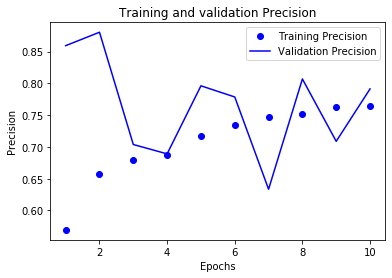

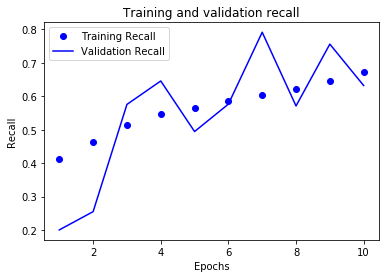

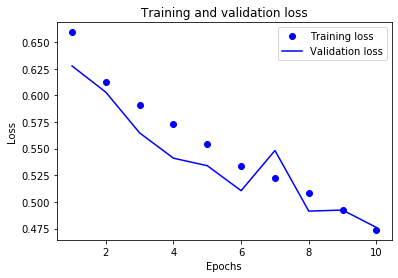

In [9]:
# As the model outputs probabilities, binary crossentropy is the best loss
# metric as it measures the distance between probability distributions
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics=[km.binary_precision(), km.binary_recall()])

model.summary()
history = model.fit(x_train,
                    y_train,
                    epochs = 10,
                    batch_size = 32,
                    validation_data = (x_val, y_val),
                    callbacks=callbacks)

# Prep history dictionary
precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(precision) + 1)

# Plot the training and validation precision
plt.plot(epochs, precision, 'bo', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot the training and validation recall
plt.clf()
plt.plot(epochs, recall, 'bo', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()


# Plot the training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# =========================
# Retrain model
# =========================

In [10]:
# model = models.Sequential()
# model.add(layers.Embedding(number_of_most_frequency_words+1, 200, input_length = train_corpus_embeddings.shape[1]))
# model.add(layers.Flatten())
# model.add(layers.Dense(32, activation = 'relu'))
# model.add(layers.Dense(1, activation = 'sigmoid'))
# model.layers[0].set_weights([embedding_matrix])
# model.layers[0].trainable = False
# 
# model.compile(optimizer = 'rmsprop',
#               loss = 'binary_crossentropy',
#               metrics=[km.binary_precision(), km.binary_recall()])
# 
# model.fit(x_train, y_train, epochs = 5, batch_size = 512)

# =========================
# Evaluate on test data
# =========================

In [11]:

# DO NOT retrain the tokenizer. Use the argument oov_token=True to reserve a
# token for unkown words. See https://bit.ly/2lNh15g

# Prepare data
# Ensure sequences are padded to the same length as training data
x_sequences = tokenizer.texts_to_sequences(test_data)
x_test = pad_sequences(x_sequences, train_corpus_embeddings.shape[1])

# Prepare labels, transform to binary and float32
y_test = test_labels.values

# Print results as ['precision', 'recall'] check names with model.metrics_names
model.evaluate(x_test, y_test)[1:]

3253/3253 [==============================] - 6s 2ms/step


[0.8101629912933688, 0.5984419263032266]

# =========================
# F1 Score
# =========================
#https://twitter.com/jessamyn/status/900867154412699649?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E900867154412699649&ref_url=https%3A%2F%2Fblog.ceshine.net%2Fpost%2Fkaggle-jigsaw-toxic-2019%2F

In [12]:
y_pred = model.predict(x_test, batch_size=32)
y_pred_roc = y_pred
y_pred = y_pred > 0.5
y_pred = y_pred.flatten()
y_pred = y_pred.astype(int)

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

print("Marco F1:%f" % f1_score(y_test, y_pred, average="macro"))
print("Micro F1:%f" % f1_score(y_test, y_pred, average="micro"))
print("Weighted F1:%f" % f1_score(y_test, y_pred, average="weighted"))


Confusion matrix:
[[1643  198]
 [ 567  845]]
Marco F1:0.749774
Micro F1:0.764832
Weighted F1:0.757870


# =========================
# ROC - AUC
# =========================
    

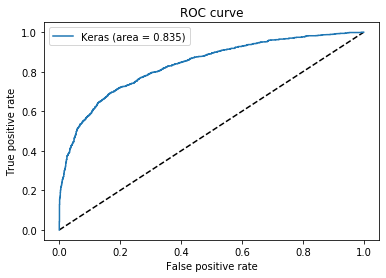

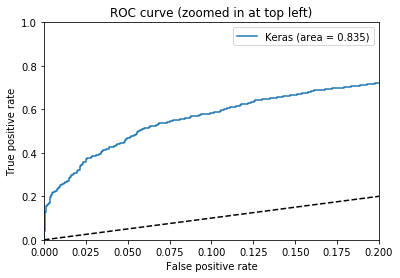

In [13]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_roc)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.0, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()